In [1]:
import os
import sys
import copy

import matplotlib.pyplot as plt
import numpy as np

import anotherpipe.powerestimation.powerestimate as pe

from pypower import PowerSpectrumSmoothWindowMatrix

sys.path.append('../bin')
from window import WindowRotation, get_data
from utils import load_poles
from local_file_manager import LocalFileName
from desi_file_manager import DESIFileName

plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plt.rcParams["figure.autolayout"] = False
plots_dir = '../../plots/'

In [2]:
source = 'desi'
mockgen = 'second'
version = 'v4_1fixran'

tracer = "ELG_LOPnotqso"
region = "GCcomb"
zrange = (1.1, 1.6)
completeness = True

ells = [0, 2, 4]

kolim = (0., 0.4)
korebin = 5
ktmax = 0.5
ktrebin = 1

rpcut = 0.
thetacut = 0.05

capsigW = 5
capsigR = 5
difflfac = 10
csub = False
covtype = 'analytic'

## Input & transformed $P(k)$, $W(k, k^{\prime})$, $C$

In [3]:
data_dir = "/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/{}/rotated_window".format(version)

rotatedwm_fn = LocalFileName().set_default_config(ftype='rotated_all', tracer=tracer, region=region, completeness=completeness, realization=None, rpcut=rpcut, thetacut=thetacut)
rotatedwm_fn.rotation_attrs['ells'] = ells
rotatedwm_fn.rotation_attrs['kobsmax'] = kolim[-1]
rotatedwm_fn.rotation_attrs['ktmax'] = ktmax
rotatedwm_fn.rotation_attrs['max_sigma_W'] = capsigW
rotatedwm_fn.rotation_attrs['max_sigma_R'] = capsigR
rotatedwm_fn.rotation_attrs['factor_diff_ell'] = difflfac
rotatedwm_fn.rotation_attrs['covtype'] = covtype
rotatedwm_fn.rotation_attrs['csub'] = csub
rotatedwm_fn.update(fdir=data_dir, zrange=zrange, cellsize=None, boxsize=None, directedges=False)
rotatedwm = WindowRotation.load(rotatedwm_fn.get_path())

wm = rotatedwm.wmatrix
cov = rotatedwm.covmatrix
mmatrix = rotatedwm.mmatrix[0] if thetacut else rotatedwm.mmatrix

In [4]:
data_nocut = get_data(source=source, catalog=mockgen, version=version, tracer=tracer, region=region, completeness=completeness, rpcut=0, thetacut=0, zrange=zrange, kolim=kolim, korebin=korebin, ktmax=ktmax, ktrebin=ktrebin, covtype=covtype)
wm_nocut = data_nocut['wmatrix']

/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v4_1fixran/complete/baseline_2pt/merged/pk/wmatrix_smooth_ELG_LOP_GCcomb_z1.1-1.6.npy


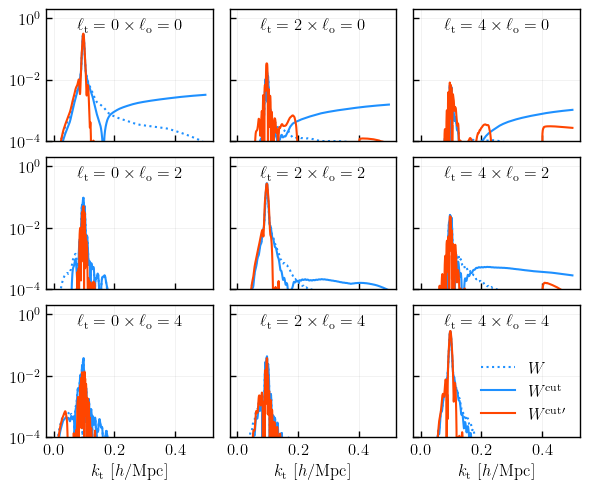

In [5]:
wm_fn = os.path.join(plots_dir, version, 'sculptedwindow_semilogy_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))
rotatedwm.plot_wmatrix(refwmatrix=wm_nocut.value.T, k=0.1, fn=wm_fn)
plt.show()

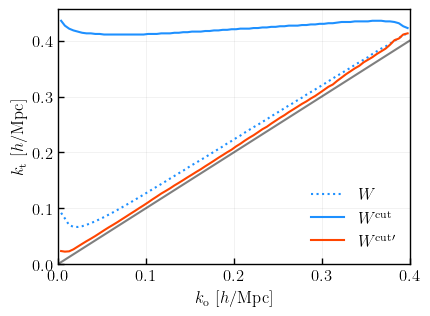

In [6]:
compactness_fn = os.path.join(plots_dir, version, 'compacity_0.95_{}_{}_{}_{}_{}_{}cut{:.2f}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))
rotatedwm.plot_compactness(frac=0.95, ells=None, klim=None, refwmatrix=wm_nocut.value.T, fn=compactness_fn)

In [7]:
pk_fn = DESIFileName()
pk_fn.set_default_config(version=version, tracer=tracer, region=region, completeness=completeness)

from utils import load_poles_list
pk = load_poles_list([pk_fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut, zrange=zrange) for imock in range(25)], xlim={ell: (kolim[0], kolim[1], 0.005) for ell in ells})

In [8]:
pk_fn.get_path()

'/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v4_1fixran/complete/baseline_2pt/mock24/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_thetacut0.05.npy'

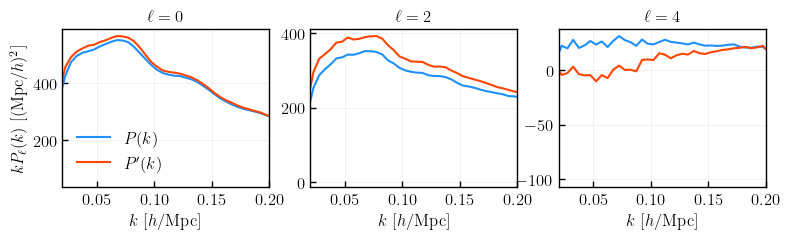

In [9]:
rotatedpk_fn = os.path.join(plots_dir, version, 'sculptedwindow_pknew_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))
rotatedwm.plot_rotated(obs=pk['data'].flatten(), fn=rotatedpk_fn)

### Transformed covariance matrix

In [10]:
covnew = rotatedwm.rotate()[1]

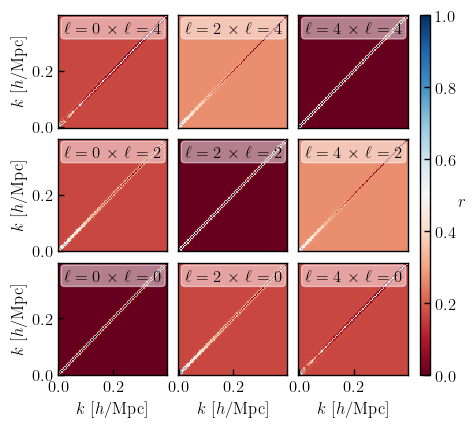

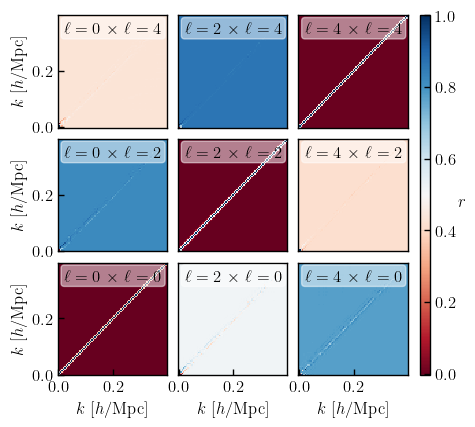

In [11]:
from cov_utils import plot_corrcoef

from matplotlib import colors
norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)

cov_fn = os.path.join(plots_dir, version, 'cov_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))
covnew_fn = os.path.join(plots_dir, version, 'rotatedcov_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))

plot_corrcoef(cov, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.savefig(cov_fn, dpi=300)
plt.show()

plot_corrcoef(covnew, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.savefig(covnew_fn, dpi=300)
plt.show()

### EZmocks covariance obtained with M from analytic covariance

In [12]:
cov_ezmocks = get_data(source=source, catalog=mockgen, version=version, tracer=tracer, region=region, rpcut=rpcut, thetacut=thetacut, zrange=zrange, kolim=kolim, korebin=korebin, ktmax=ktmax, ktrebin=ktrebin, covtype='ezmocks')['covariance']

/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v4_1fixran/complete/baseline_2pt/merged/pk/wmatrix_smooth_ELG_LOP_GCcomb_z1.1-1.6_thetacut0.05.npy
Loading EZmocks covariance: /global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_ELG_LOP_ffa_GCcomb_z1.100-1.600_k0.00-0.40_thetacut0.05.npy


In [13]:
covnew_ezmocks = np.matmul(np.matmul(mmatrix, cov_ezmocks), mmatrix.T) #- np.sum(np.array([np.array(sculptwm.m)[i] * np.outer(mo[i], mo[i]) for i in range(len(ells))]), axis=0)

In [14]:
ezmocks_cov_fn = os.path.join(plots_dir, version, 'ezmocks_cov_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))
ezmocks_covnew_fn = os.path.join(plots_dir, version, 'rotated_ezmocks_cov_{}_{}_{}_{}_{}_{}cut{:.2f}_ells{}_maxsigW{}_maxsigR{}_factordiffell{}_{}cov{}.pdf'.format(tracer, 'complete' if completeness else 'altmtl', region, zrange[0], zrange[1], 'rp' if rpcut else 'theta', max(rpcut, thetacut), ''.join([str(i) for i in ells]), capsigW, capsigR, difflfac, covtype, '_csub' if csub else ''))

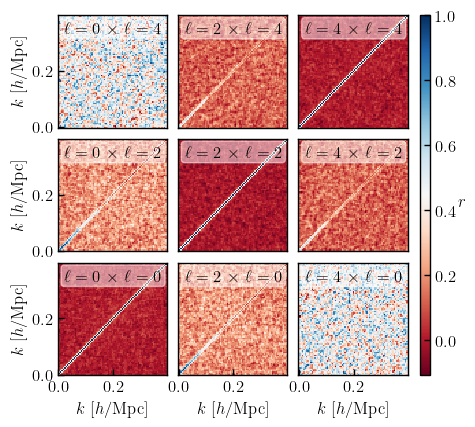

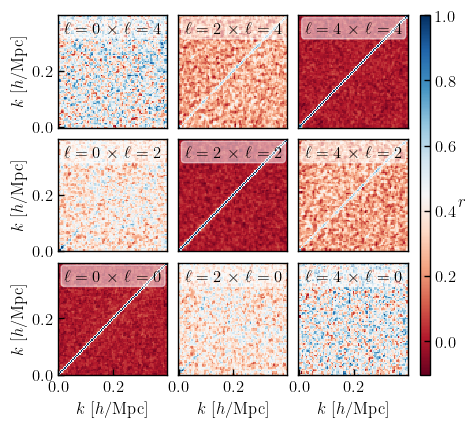

In [15]:
plot_corrcoef(cov_ezmocks, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.savefig(ezmocks_cov_fn, dpi=300)
plt.show()

plot_corrcoef(covnew_ezmocks, ells, np.arange(kolim[0], kolim[1], 0.005))
plt.savefig(ezmocks_covnew_fn, dpi=300)
plt.show()